# EMPIRICAL MACROECONOMICS
Francesco Franco, Nova SBE
## Non-fundamental Shocks: Replication of Ben S. Bernanke, Jean Boivin and Piotr Eliasz QJE 2005
**Measuring the Effects of Monetary Policy: A Factor-Augmented Vector Autoregressive(FAVAR) Approach. The Quarterly Journal of Economics, Vol. 120, No. 1 (Feb., 2005), pp. 387-422**

Refer to paper and class notes. Notation try to be consistent with paper.

# PART 1

In [1]:
'''Importing packages and functions''' 

import os                                # operating system
import pandas as pd                      # pandas
import numpy as np                       # numpy
from numpy import linalg as LA
from numpy.linalg import inv, multi_dot  # linear algebra from numpy for PCA
import matplotlib.pyplot as plt          # figures
%matplotlib inline                       

In [2]:
'''Load data set'''

#Change to your directory and put csv in it
#os.chdir(r"")

df = pd.read_csv("nsbalpanel.csv",header=None)       #load data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 479.2 KB


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.01340,0.00861,0.00732,0.00523,0.00952,0.0133,0.01880,0.03120,0.04500,0.01740,...,0.00473,0.00000,0.00000,0.00436,0.00000,0.00000,0.00000,0.00348,0.00462,95.8
1,0.00602,0.00492,0.00000,0.01940,-0.00475,0.0107,0.01390,0.02560,0.03870,0.01490,...,0.00471,-0.00301,0.00524,0.00000,0.00000,0.00000,0.00000,-0.00348,0.00917,96.4
2,0.01430,0.01450,0.01570,0.00640,0.01650,0.0258,0.01600,0.02730,0.02970,0.03050,...,0.00000,0.00000,0.00000,0.00434,0.00345,0.00000,0.00000,0.00694,0.00456,96.9
3,0.00829,0.00956,0.00476,0.02010,0.00000,0.0319,0.00564,0.02540,0.03410,0.00892,...,0.00468,0.00301,0.00261,0.00432,0.00344,0.00000,0.00000,0.00690,0.00000,97.5
4,0.00704,0.00714,-0.00476,0.00746,-0.00703,0.0233,0.00337,-0.00659,-0.00736,-0.00301,...,0.00466,0.00000,0.00000,0.00000,0.00343,0.00325,0.00337,0.00343,0.00454,97.2


In [3]:
'''
   Data Description in Appendix1 page 416-420
   The transformation codes are:
   1:no transformation
   2:first difference
   4:logarithm
   5:first difference of logarithm.
   An asterisk *, next to the mnemonic, denotes a variable assumed to be slow-moving in the estimation
'''

# let us keep the indexes of the slow-moving variables

slowvars  = list(range(0,53))+list(range(102,119))   # remember that index in python starts with 0, therefore
                                                     # need to take out 1 from numbers in appendix
                                                     # furthermore range is closed on the left and open on the right
        
# let us keep the indexes of the variables for which they compute IRFs

xvars     = [15,106,76,79,90,91,94,73,100,16,48,23,45,53,61,66,117,118]
             
var_names = ['IP','CPI','3m TREASURY BILLS','5y TREASURY BONDS','M1','M2','MONETARY BASE',
             'EXCHANGE RATE YEN','COMMODITY PRICE INDEX','CAPACITY UTIL RATE',
            'PERSONAL CONSUMPTION','EMPLOYMENT','AVG WEEKLY HOURS',             
            'HOUSING STARTS','NEW ORDERS','S&Ps COMPOSITE','AVG HOURLY EARNINGS',
            'CONSUMER EXPECTATIONS']

In [4]:
'''Transforming the data'''

stdffr = df.loc[:,76].std()  # keep std of the ffr
df     = df.apply(lambda x: (x-x.mean())/x.std())

Consider the case where you observe one factor without error $Y_t=ffr_t$
$$\mathcal{X}_{t}=\Lambda\left[\begin{array}{c}
Y_{t}\\
F_{t}
\end{array}\right]+\left[\begin{array}{c}
0\\
e_{t}
\end{array}\right]$$

In [5]:
'''Specification: what is observable'''
# a couple of alternatives
df_np = df.values
Y = df_np[:,76]
X = np.delete(df_np,76,1)

In [8]:
Y =np.expand_dims(Y, axis=1)

In [10]:
''' Parameters '''

num_factors = 3                 # Change to increase number of factors to be extracted
N           = X.shape[1]        # number of series 
T           = X.shape[0]        # number of observations
M           = Y.shape[1]        # number of series considered observables factors
K           = num_factors
# number of periods for IRFS 
num_impulses = 40
num_lags     = 13
iter1        = 1
iter2        = 100


## PCA computing the eigenvalues and eigenvectors
This is the Linear Algebra algorithm that is widely used because numerically stable. In the notes we have that • The estimators of $F_{t}$ and $\Lambda$ solve the minimization problem$$\min_{\left\{ F_{i}\right\} _{i=1}^{T},\Lambda}\left(NT\right)^{-1}\sum_{t=1}^{T}\left[\mathcal{X}_{t}-\Lambda F_{t}\right]'\left[\mathcal{X}_{t}-\Lambda F_{t}\right]$$subject to $N^{-1}\Lambda'\Lambda=I_{r}.$

Under our simplified assumptions $\hat{F}_{t}=N^{-1}\hat{\Lambda}'\mathcal{X}_{t}$ and $\hat{\Lambda}$ is the matrix of eigenvectors (multiplied by $\sqrt{N}$) of the sample variance matrix of  $\mathcal{X}_{t}.$ 
Remember that a square matrix can be decomposed as $$\mathcal{X}'\mathcal{X}=VSV^{-1}$$ where $V$ are the eigenvectors and $S$ the eigenvalues. Now our covariance matrix is $$\frac{\mathcal{X}'\mathcal{X}}{N}$$ therefore $\Lambda=\sqrt{N}V$

In [11]:
def extract_eig(x,nf):
    '''
    Compute the factors with the eigenvalues eigenvectors decomposition
    Inputs:  x the data
             nf number of factors
    Outputs: lam the factor loadings
             fac the factors  
    '''
    x = np.array(x)
    xx = x.T@x 
    s, V = LA.eig(xx)
    W = V[:,:nf]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]
    return fac, lam 

## PCA using the SVD decomposition
The SVD decomposition is practical because always exists and says that $\mathcal{X}=VSU'$ where $V$ and $U$ are orthonormals. Therefore $$\mathcal{X}'\mathcal{X}=VSU'USV'=VS^{2}V'$$ and we can see that $V$ is our $\Lambda$ (divided by  $\sqrt{N}$).

In [12]:
def extract_svd(x,nf):
    '''
    Compute the factors with SVD
    Inputs:  x the data
             nf number of factors
    Outputs: lam the factor loadings
             fac the factors  
    '''     
    x = np.array(x)
    U, s , V = LA.svd(x)
    W = V.T[:,:nf]
    lam = W*np.sqrt(x.shape[1])
    fac = x@lam/x.shape[1]    
    return fac, lam 

## Slow-R-Fast identification scheme
the Bernanke, Boivin, and Eliasz (2005) implementation of the slow-R-fast identification scheme starts from 
$$\mathcal{X}_{t}=\Lambda F_{t}+e_{t}$$
and divide the factors into slow-moving and fast-moving
$$\begin{bmatrix}\mathcal{X}_{t}^{s}\\
\mathcal{X}_{t}^{f}
\end{bmatrix}=\begin{bmatrix}\Lambda_{ss} & 0 & 0\\
\Lambda_{fs} & \Lambda_{fr} & \Lambda_{ff}
\end{bmatrix}\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}+e_{t}$$
or $$\mathcal{X}_{t}^{s}=\Lambda_{ss}F_{t}^{s}+e_{t}^{s}$$ $$\mathcal{X}_{t}^{f}=\Lambda_{fs}F_{t}^{s}+\Lambda_{fr}R_{t}+\Lambda_{ff}F_{t}^{f}+e_{t}^{f}$$
And
$$\begin{bmatrix}F_{t}^{s}\\
R_{t}\\
F_{t}^{f}
\end{bmatrix}=\Phi(L)\begin{bmatrix}F_{t-1}^{s}\\
R_{t-1}\\
F_{t-1}^{f}
\end{bmatrix}+\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}$$

In the paper (p.405) they decribe the following procedure:
- get $F_{t}$ from the $\mathcal{X}_{t}$ whole dataset.
- get $F_{t}^{s}$ from the $\mathcal{X}_{t}^{s}$ sub-dataset.
- regress $F_{t}=\beta_{s}F_{t}^{s}+\beta_{r}R_{t}+u_{t}$
- $F_{t}^{r}=F_{t}-\hat{\beta}_{r}R_{t}$

In [13]:
def cleanfac(F,pol,Fs):
    '''
    computes the factors as described in p.405 of the paper
    Inputs:  F:   Unrestricted PC estimates (from all the dataset)
             pol: policy instrument
             Fs:  Proxy of the slow moving factors
    Outputs: Fr: factors cleaned from pol
    '''
    F, Fs, pol = np.array(F),np.array(Fs),np.array(pol)
    Fs = np.hstack([Fs, pol])
    betas = LA.inv(Fs.T@Fs)@Fs.T@F
    Fr = F - np.dot(pol,betas[num_factors:,:])
    #Fr = pd.DataFrame(Fr)
    
    return Fr

In [14]:
'''
Extract factors and clean them from observables effects
''' 
F, LAMBDA = extract_svd(X,K)
xs = df.loc[:,df.columns[slowvars]]
Fs,LAMBDAs = extract_svd(xs,K)
Fr = cleanfac(F,Y,Fs)
et = X-F@LAMBDA.T  # keep the residuals

We estimate the VAR $$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+\eta_{t}$$ then invert to obtain the IRF:$$X_{t}	=C(L)^{-1}\eta_{t}$$ or
$$X_{t}	=\eta_{t}+C(1)\eta_{t-1}+...$$ and identify the strucrural shocks : $$X_{t}	=A(0)\epsilon_{t}+C(1)A(0)\epsilon_{t-1}+...$$
Using

$$
\begin{bmatrix}\eta_{t}^{s}\\
\eta_{t}^{r}\\
\eta_{t}^{f}
\end{bmatrix}=\begin{bmatrix}1 & 0 & 0\\
A_{rs} & 1 & 0\\
A_{fs} & A_{fr} & 1
\end{bmatrix}\begin{bmatrix}\epsilon_{t}^{s}\\
\epsilon_{t}^{r}\\
\epsilon_{t}^{f}
\end{bmatrix}$$

This short run identification is implemented using the Choleski decomposition:

here $$\hat{\eta}'\hat{\eta} = \hat{\Omega} = A(0)'\epsilon\epsilon A(0)$$

Now use $\epsilon\epsilon = \left[\begin{array}{ccc}
\sigma_{1}^{2} & 0 & 0\\
0 & \sigma_{2}^{2} & 0\\
0 & 0 & \sigma_{fed}^{2}
\end{array}\right]$

and use the Cholesky  decomposition. For every symetric matrix  $A(0) = LL'$
where $L$ is lower triangular. We then transform the lower triangular matrix
in a matrix with ones on the diagonal by dividing by the diagional of $L$.

### Let us construct a Class like we did for BQ paper
Basically we are combining all the steps we did above

In [18]:
'''
We can build our own VAR Class for the Short Run Identification
And we have options in how to program it
here with numpy
'''
class VAR_np_class2():
    
    def __init__(self,X,xsub,lags,shock,num_impulses=40):
        
        self.X = X
        self.xsub = xsub
        self.lags = lags
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0] - self.lags
        self.num_impulses = num_impulses
        self.shock = shock
        
    def XLAGp(self):       
        XLAG = np.vstack((np.empty((1,4)),self.X[0:-1,:]))
        for i in range(2,self.lags+1):
            tmp1 = np.vstack((np.empty((i,4)),self.X[0:-i,:]))
            XLAG = np.hstack((XLAG,tmp1))
        X2 = self.X[self.lags:,:]
        XLAG2 = XLAG[self.lags:,:]
        return X2, XLAG2
    
    def fit(self):
        X2, XLAG2 = self.XLAGp()
        Bhat = inv(XLAG2.T@XLAG2)@XLAG2.T@X2
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars),
                                              np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
       
        return Bhat, c_Bhat
    
    def IRF(self):
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        
        Bhat,c_Bhat = self.fit()
        X2, XLAG2 = self.XLAGp()
        EPS = (X2 - XLAG2@Bhat)
        #estimated covariance matrix
        Omegahat = EPS.T@EPS/(self.num_obs - self.lags*self.num_vars - 1)      
        #Setting up for SR restriction
        A0 = LA.cholesky(Omegahat)
        d = np.zeros(A0.shape)
        np.fill_diagonal(d,np.diag(A0))
        A0 = np.dot(np.linalg.inv(d),A0)
        F = inv(A0)
        ETA = EPS@F.T
        psi  = []
        Temp = np.identity(c_Bhat.shape[0])
        for t in range(self.num_impulses):
            psi_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = psi_t@A0         # store the IRF
            Temp = c_Bhat@Temp            # computes the exponent of the matrix
            #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

        
        IRF   = IRF@self.shock 
        
        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
        #irf.columns = ["s_y","d_y","s_u","d_u"]
        irf_cum = irf.cumsum() #output is expressed cumulatively
        # xsub is the subset of X that they study in the paper
        
        bx   = LA.inv(self.X.T@self.X)@self.X.T@self.xsub
        irf_sub = irf@bx
        return A0,EPS,ETA,irf,irf_cum,irf_sub       

In [19]:
'''
Prepare the data
'''
Xvar = np.hstack((Fr,Y))
xsub = X[:,xvars]
# Shock
shock = np.hstack([np.zeros([1,K+M-1]), np.ones([1,1])*0.25/stdffr])
shock = shock.T

In [20]:
prova = VAR_np_class2(Xvar,xsub,13,shock)

In [21]:
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()

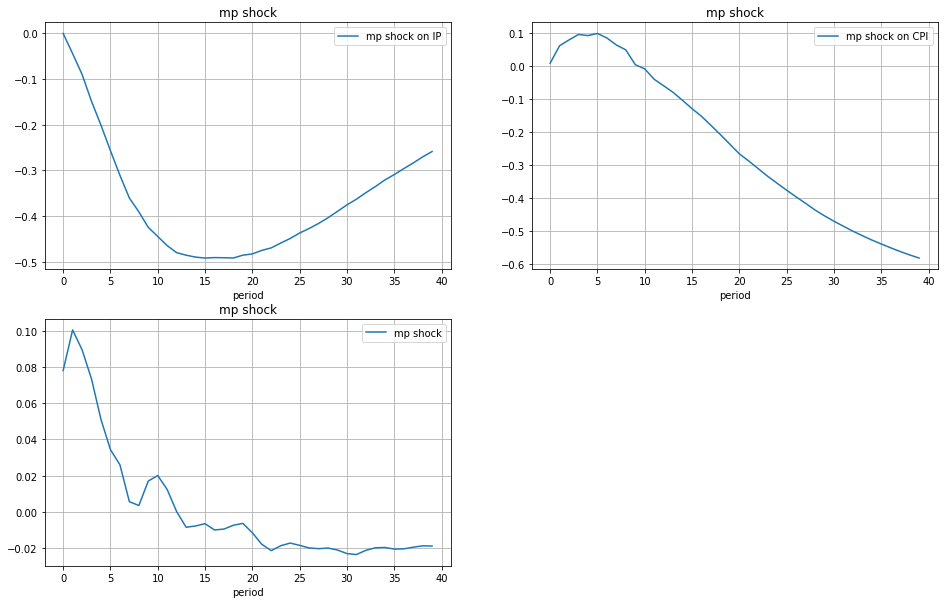

In [23]:
# Plot the IRFs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1,label='mp shock on IP')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1,label='mp shock on CPI')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

plt.subplot(223)
plt.plot(irf[3],label='mp shock')
plt.legend()
plt.xlabel('period')
plt.title('mp shock')
plt.grid()

# PART II

Bootstrapping the IRF

The issue can be understood as follows. When we estimate the VAR $$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+v_{t}$$ then invert to obtain the IRF:$$X_{t}	=C(L)^{-1}v_{t}$$ or
$$X_{t}	=v_{t}+C(1)v_{t-1}+...$$ or on the strucrural shocks : $$X_{t}	=A(0)\epsilon_{t}+C(1)A(0)\epsilon_{t-1}+...$$
we are :
- estimtating $B(L)$ with OLS, therefore subject to small sample bias (on top of the issues due to autocorelation not handled well), same for the covariance of the innovations (reduced form residuals)
- obtain the IRF from the non linear transformation of the $B(L)$ and of the covariance
.This can result in substantially biased IRF.

# Bootstrapping
Loop2 is nested in Loop1. Denote by $it_1=N_1$ a replication of loop 1
1. Loop1: Reshuffle $e_t$ and obtain $e_t^*$

    Compute $$\mathcal{X_{t}^{it_1}}=\hat{\Lambda} F_{t}+e_{t}^*$$

    Use the function extract factors to get $F_{t}^{r,it}=F_{t}^{it_1}-\hat{\beta^{it}}_{r}R_{t}$
    
    
2. Loop2: Reshuffle $v_t$ and obtain $v_t^*$. Here scale the redisuals.
    
    Estimate the VAR(p) and generate $it_2=N_2$ bootstrap replications of $\hat{B^{it_2}}$ from
    
    $$X^{it_2}_{t}=\hat{B}(1)X^{it_2}_{t-1}+\hat{B}(2)X^{it_2}_{t-2}+...+v^{it_2}_{t}$$
    
    Identify $A(0)^{it_2}$
    
    Compute the IRFs $$\hat{X}_{t+s}^{it_2}=\sum_{i=0}^{s-1}C_{i}^{it_2}A(0)^{it_2}\eta_{t+s-i}^{it_2}$$
    
3. Sort the $it_1*it_2$ and IRFs keep the 5,and 95 percintile 

In [24]:
def extract_fac(x,Y,K,slowvars):
    '''
    Routine to extract the factors
    1. Extract factors from whole dataset F
    2. Extract factors from slow moving dataset Fslow
    3. Regress factors F on Flsow and Y and subtract effect of Y from F to obtain Fr
    '''
    x =  pd.DataFrame(x)
    xs = x.loc[:,x.columns[slowvars]]
    F,Lf = extract_svd(x,K)
    Fs , Lfs = extract_svd(xs,K)
    Fr = cleanfac(F,Y,Fs)    
    return Fr

## Inner Loop 

As a first step just look at CI with uncertainty on VAR estimates

In [25]:
'''
Bootstrap of the confidence intervals
This firt example only consider Loop2
'''

iter2 = 100
num_vars = M+K
num_obs = Xvar.shape[0] - 13
#Containers for IRF
IRF_var = np.zeros([num_impulses*(M+K),iter2])
IRF_xsub = np.zeros([num_impulses*xsub.shape[1],iter2])
# Start
bx   = LA.inv(Xvar.T@Xvar)@Xvar.T@xsub
ex   = xsub - Xvar@bx
ex_r = ex.copy()
prova = VAR_np_class2(Xvar,xsub,13,shock)
Bhat,c_Bhat = prova.fit()
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()
G0_hat = np.vstack((np.eye(num_vars),np.zeros([(num_lags-1)*num_vars,num_vars])))
scale = np.sqrt(num_obs/(num_obs - num_lags*num_vars))
EPS_r = scale*EPS.copy()
for it in range(iter2):
    
    np.random.shuffle(EPS_r)    
    X_r = np.zeros([num_vars,num_lags])
    X_init_r = Xvar.copy()
    np.random.shuffle(X_init_r)
    for i in range(num_lags):
        X_r[:,num_lags-i-1]=X_init_r[i,:]
    X_r = np.reshape(X_r,(num_lags*num_vars,1),order='F')
    X_r = np.hstack((X_r,np.zeros([num_lags*num_vars,num_obs-1])))        
    for t in range(num_obs-1):
        X_r[:,t+1] = np.dot(c_Bhat,X_r[:,t])+ np.dot(G0_hat,EPS_r.T[:,t])
    datasim = np.vstack((X_init_r[0:num_lags],X_r[0:4,:].T))    
   
    np.random.shuffle(ex_r)
    xsub_r = datasim@bx + ex_r      
    prova = VAR_np_class2(datasim,xsub_r,13,shock)
    A0_ci,EPS_ci,ETA_ci,irf_ci,irf_cum_ci,irf_sub_ci = prova.IRF()
    IRF_var[:,it]  = np.reshape(np.array(irf_ci),(num_impulses*(1+num_factors),1)).flatten()
    IRF_xsub[:,it] = np.reshape(np.array(irf_sub_ci),((num_impulses*len(xvars)),1)).flatten()

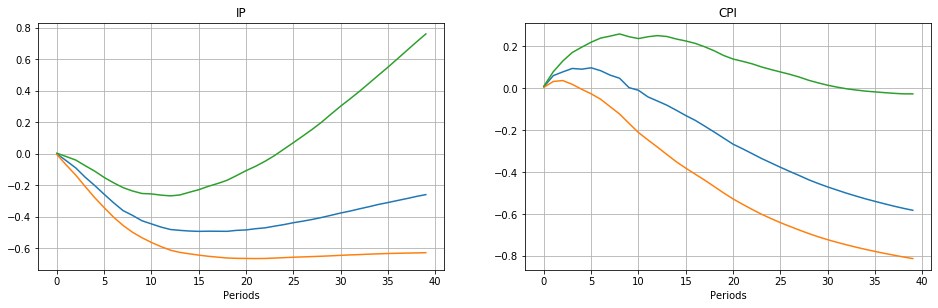

In [26]:
# KEEP THE 5% - 95% IRF sorted 
IRF_var        = IRF_var.reshape(num_impulses,M+K,iter1*iter2)
IRF_xsub       = IRF_xsub.reshape(num_impulses,len(xvars),iter1*iter2)
IRF_var        = np.sort(IRF_var,axis=2)
IRF_xsub       = np.sort(IRF_xsub,axis=2)
iter_tot       = iter1*iter2
IRF_varci      = IRF_var[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]
IRF_xsubci     = IRF_xsub[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]

# PLOT THE IRS WITH CI

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,1]))-1)
plt.xlabel('Periods')
plt.title('IP')
plt.grid()
plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,1]))-1)
plt.xlabel('Periods')
plt.title('CPI')
plt.grid()


## Outer and Inner loops

Lets us now have the two loops (careful on the number of replications)

In [28]:
'''
Bootstrap of the confidence intervals
This example consider Loop1 and Loop2
'''
iter1 = 10
iter2 = 100
num_vars = M+K
num_obs = Xvar.shape[0] - 13
IRF_var = np.zeros([num_impulses*(M+K),iter1*iter2])
IRF_xsub = np.zeros([num_impulses*xsub.shape[1],iter1*iter2])

bx   = LA.inv(Xvar.T@Xvar)@Xvar.T@xsub
ex   = xsub - Xvar@bx
ex_r = ex.copy()
prova = VAR_np_class2(Xvar,xsub,13,shock)
A0,EPS,ETA,irf,irf_cum,irf_sub = prova.IRF()
G0_hat = np.vstack((np.eye(num_vars),np.zeros([(num_lags-1)*num_vars,num_vars])))
scale = np.sqrt(num_obs/(num_obs - num_lags*num_vars))
EPS_r = scale*EPS.copy()
et_rep = et.copy()
iteration=0
for rep in range(iter1):
    np.random.shuffle(et_rep)
    X_star = F@LAMBDA.T+ et_rep
    # get the factors from the new dataset
    Fr_star = extract_fac(X_star,Y,K,slowvars)
    Xvar_rep = np.hstack((Fr_star, Y))
    
    bx_rep = LA.inv(Xvar_rep.T@Xvar_rep)@Xvar_rep.T@xsub
    ex_rep = xsub - Xvar_rep@bx_rep
    
    prova_rep = VAR_np_class2(Xvar_rep,xsub,13,shock)
    Bhat_rep,c_Bhat_rep = prova_rep.fit()
    A0_rep,EPS_rep,ETA_rep,irf_rep,irf_rep_cum_rep,irf_sub_rep = prova_rep.IRF()
    EPS_r = scale*EPS_rep.copy()
    for it in range(iter2):
        iteration=iteration+1
    
        np.random.shuffle(EPS_r)    
        X_r = np.zeros([num_vars,num_lags])
        X_init_r = Xvar_rep.copy()
        np.random.shuffle(X_init_r)
        for i in range(num_lags):
            X_r[:,num_lags-i-1]=X_init_r[i,:]
        X_r = np.reshape(X_r,(num_lags*num_vars,1),order='F')
        X_r = np.hstack((X_r,np.zeros([num_lags*num_vars,num_obs-1])))        
        for t in range(num_obs-1):
            X_r[:,t+1] = np.dot(c_Bhat_rep,X_r[:,t])+ np.dot(G0_hat,EPS_r.T[:,t])
        datasim = np.vstack((X_init_r[0:num_lags],X_r[0:4,:].T))    
   
        np.random.shuffle(ex_rep)
        xsub_r = datasim@bx_rep + ex_rep      
        prova = VAR_np_class2(datasim,xsub_r,13,shock)
        A0_ci,EPS_ci,ETA_ci,irf_ci,irf_cum_ci,irf_sub_ci = prova.IRF()
        IRF_var[:,iteration-1]  = np.reshape(np.array(irf_ci),(num_impulses*(1+num_factors),1)).flatten()
        IRF_xsub[:,iteration-1] = np.reshape(np.array(irf_sub_ci),((num_impulses*len(xvars)),1)).flatten()

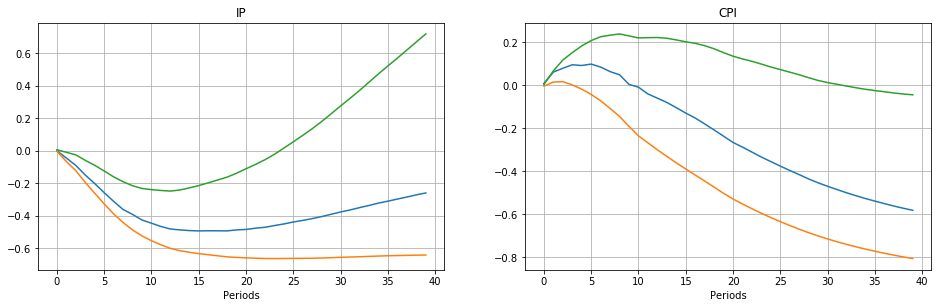

In [29]:
# KEEP THE 5% - 95% IRF sorted 
IRF_var        = IRF_var.reshape(num_impulses,M+K,iter1*iter2)
IRF_xsub       = IRF_xsub.reshape(num_impulses,len(xvars),iter1*iter2)
IRF_var        = np.sort(IRF_var,axis=2)
IRF_xsub       = np.sort(IRF_xsub,axis=2)
iter_tot       = iter1*iter2
IRF_varci      = IRF_var[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]
IRF_xsubci     = IRF_xsub[:,:,[np.int(0.05*iter_tot),np.int(0.95*iter_tot)]]

# PLOT THE IRS WITH CI

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,0,1]))-1)
plt.xlabel('Periods')
plt.title('IP')
plt.grid()
plt.subplot(222)
plt.plot(np.exp(np.cumsum(irf_sub[1]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,1,1]))-1)
plt.xlabel('Periods')
plt.title('CPI')
plt.grid()



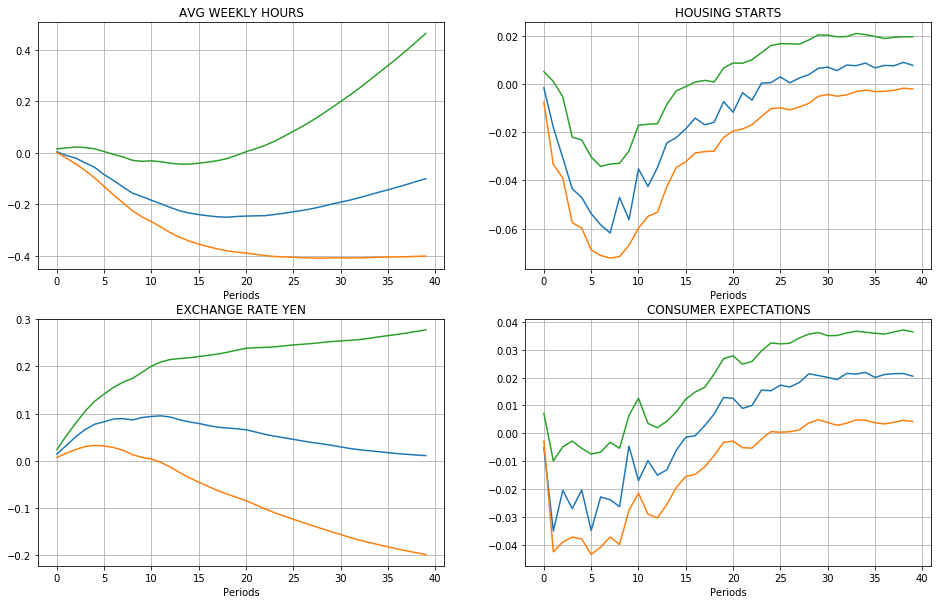

In [30]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(np.exp(np.cumsum(irf_sub[12]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,12,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,12,1]))-1)
plt.xlabel('Periods')
plt.title(var_names[12])
plt.grid()
plt.subplot(222)
plt.plot(np.exp(irf_sub[13])-1)
plt.plot(np.exp(IRF_xsubci[:,13,0])-1)
plt.plot(np.exp(IRF_xsubci[:,13,1])-1)
plt.xlabel('Periods')
plt.title(var_names[13])
plt.grid()
plt.subplot(223)
plt.plot(np.exp(np.cumsum(irf_sub[7]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,7,0]))-1)
plt.plot(np.exp(np.cumsum(IRF_xsubci[:,7,1]))-1)
plt.xlabel('Periods')
plt.title(var_names[7])
plt.grid()
plt.subplot(224)
plt.plot(irf_sub[17])
plt.plot(IRF_xsubci[:,17,0])
plt.plot(IRF_xsubci[:,17,1])
plt.xlabel('Periods')
plt.title(var_names[17])
plt.grid()